### NAME:KABINA GIRI 
### AI LAB ASSIGNMENT :Binary Classification with Neural Networks (circles dataset)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.optim as optim

# Reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Device
device = "cuda" if torch.cuda.is_available() else "cpu"
device


'cpu'

### Data retrieval & inspection

In [ ]:
# Load CSV
df = pd.read_csv("circles_binary_classification.csv")
df.head()


,X1,X2,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0


In [6]:
# Summary statistics
df.describe()


,X1,X2,label
count,1000.000000,1000.000000,1000.00000
mean,-0.000448,-0.000804,0.50000
std,0.639837,0.641156,0.50025
min,-1.059502,-1.067768,0.00000
25%,-0.619251,-0.612176,0.00000
50%,0.008762,-0.003949,0.50000
75%,0.621933,0.624822,1.00000
max,1.033712,1.036004,1.00000


### Data cleaning & feature design

In [7]:
# Check missing values
df.isnull().sum()


X1       0
X2       0
label    0
dtype: int64

In [9]:
# Features and target
X = df[['X1', 'X2']].values
y = df['label'].values

# Convert to tensors
X = torch.tensor(X, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.float32)


3.Visualize data

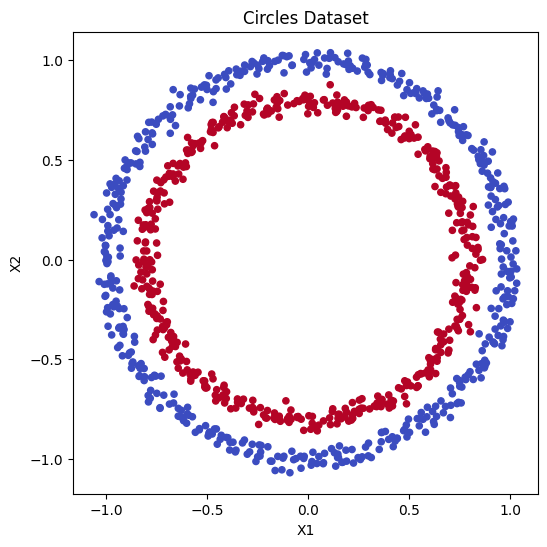

In [10]:
plt.figure(figsize=(6,6))
plt.scatter(X[:,0], X[:,1], c=y, cmap='coolwarm', s=20)
plt.xlabel("X1")
plt.ylabel("X2")
plt.title("Circles Dataset")
plt.show()


### Train/test split

In [11]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Move to device
X_train, X_test = X_train.to(device), X_test.to(device)
y_train, y_test = y_train.to(device), y_test.to(device)


5.Device & dtype

In [12]:
# Accuracy
def accuracy_fn(y_true, y_pred):
    return (y_true == y_pred).sum().item() / len(y_pred)


In [14]:
# Decision boundary plot
def plot_decision_boundary(model, X, y):
    model.eval()
    
    x_min, x_max = X[:,0].min() - 0.5, X[:,0].max() + 0.5
    y_min, y_max = X[:,1].min() - 0.5, X[:,1].max() + 0.5
    
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100),
                         np.linspace(y_min, y_max, 100))
    
    grid = torch.tensor(np.c_[xx.ravel(), yy.ravel()],
                        dtype=torch.float32).to(device)
    
    with torch.no_grad():
        logits = model(grid).squeeze()
        probs = torch.sigmoid(logits)
        preds = torch.round(probs)
    
    zz = preds.reshape(xx.shape).cpu().numpy()
    
    plt.contourf(xx, yy, zz, alpha=0.3, cmap='coolwarm')
    plt.scatter(X[:,0].cpu(), X[:,1].cpu(), c=y.cpu(), cmap='coolwarm', s=20)
    plt.show()


### Training & Evaluation Loop

In [15]:
def train_and_test_loop(model, optimizer, loss_fn, epochs):
    train_losses, test_losses = [], []
    train_accs, test_accs = [], []
    
    for epoch in range(epochs):
        # Training
        model.train()
        logits = model(X_train).squeeze()
        loss = loss_fn(logits, y_train)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        preds = torch.round(torch.sigmoid(logits))
        acc = accuracy_fn(y_train, preds)
        train_losses.append(loss.item())
        train_accs.append(acc)
        
        # Evaluation
        model.eval()
        with torch.no_grad():
            test_logits = model(X_test).squeeze()
            test_loss = loss_fn(test_logits, y_test)
            test_preds = torch.round(torch.sigmoid(test_logits))
            test_acc = accuracy_fn(y_test, test_preds)
            test_losses.append(test_loss.item())
            test_accs.append(test_acc)
        
        if epoch % 10 == 0:
            print(f"Epoch {epoch} | Train Loss: {loss:.4f}, Train Acc: {acc:.4f} | "
                  f"Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}")
    
    return train_losses, test_losses, train_accs, test_accs


### Model V0 (2 → 5 → 1, No Activation)

In [16]:
class ModelV0(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(2, 5),
            nn.Linear(5, 1)
        )
    def forward(self, x):
        return self.net(x)


model_v0 = ModelV0().to(device)
loss_fn = nn.BCEWithLogitsLoss()
optimizer = optim.SGD(model_v0.parameters(), lr=0.1)

train_losses, test_losses, _, _ = train_and_test_loop(model_v0, optimizer, loss_fn, 100)
plot_decision_boundary(model_v0, X_train, y_train)


### Model V1 (2 → 15 → 15 → 1, No Activation)

In [17]:
class ModelV1(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(2, 15),
            nn.Linear(15, 15),
            nn.Linear(15, 1)
        )
    def forward(self, x):
        return self.net(x)


model_v1 = ModelV1().to(device)
optimizer = optim.SGD(model_v1.parameters(), lr=0.1)

train_and_test_loop(model_v1, optimizer, loss_fn, 1000)
plot_decision_boundary(model_v1, X_train, y_train)


### Model V2 (Nonlinear, ReLU)

In [18]:
class ModelV2(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(2, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, 10),
            nn.ReLU(),
            nn.Linear(10, 1)
        )
    def forward(self, x):
        return self.net(x)


model_v2 = ModelV2().to(device)
optimizer = optim.SGD(model_v2.parameters(), lr=0.1)

train_losses, test_losses, _, _ = train_and_test_loop(model_v2, optimizer, loss_fn, 1000)
plot_decision_boundary(model_v2, X_test, y_test)


## 7. Loss Function, Optimizer, and Metrics

In this step, the loss function, optimizer, and evaluation metric are defined.
Binary Cross-Entropy loss with logits is used for numerical stability.


In [20]:
model = ModelV0().to(device)


In [21]:
# Loss function (raw logits)
loss_fn = nn.BCEWithLogitsLoss()

# Optimizer (NOW model exists, so this works)
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)

# Accuracy metric
def accuracy_fn(y_true, logits):
    probs = torch.sigmoid(logits)
    preds = torch.round(probs)
    return (preds == y_true).sum().item() / len(y_true)


## 8. Training Loop

A unified training and evaluation loop is implemented.  
The model is trained and evaluated at every epoch, while losses and accuracies
are recorded. Progress is printed every 10 epochs.


In [23]:
def train_and_test_loop(model, optimizer, epochs):
    train_losses, test_losses = [], []
    train_accuracies, test_accuracies = [], []

    for epoch in range(epochs):

        # -------- TRAINING --------
        model.train()
        train_logits = model(X_train).squeeze()
        train_loss = loss_fn(train_logits, y_train)

        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()

        train_acc = accuracy_fn(y_train, train_logits)

        # -------- EVALUATION --------
        model.eval()
        with torch.no_grad():
            test_logits = model(X_test).squeeze()
            test_loss = loss_fn(test_logits, y_test)
            test_acc = accuracy_fn(y_test, test_logits)

        # Store results
        train_losses.append(train_loss.item())
        test_losses.append(test_loss.item())
        train_accuracies.append(train_acc)
        test_accuracies.append(test_acc)

        # Print progress
        if epoch % 10 == 0:
            print(
                f"Epoch {epoch} | "
                f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} | "
                f"Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}"
            )

    return train_losses, test_losses, train_accuracies, test_accuracies


### Reinitialization of Model and Optimizer

Before training each model variant, the model and optimizer are reinitialized
to ensure fair comparison between different architectures.


###  Model V0

In [24]:
# Reinitialize Model V0
model = ModelV0().to(device)

# Reinitialize Optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)

# Train
train_losses_v0, test_losses_v0, train_accs_v0, test_accs_v0 = train_and_test_loop(
    model, optimizer, epochs=100
)


Epoch 0 | Train Loss: 0.6980, Train Acc: 0.5188 | Test Loss: 0.6944, Test Acc: 0.5800
Epoch 10 | Train Loss: 0.6959, Train Acc: 0.5125 | Test Loss: 0.6931, Test Acc: 0.5300
Epoch 20 | Train Loss: 0.6949, Train Acc: 0.5162 | Test Loss: 0.6925, Test Acc: 0.4950
Epoch 30 | Train Loss: 0.6943, Train Acc: 0.5112 | Test Loss: 0.6924, Test Acc: 0.4950
Epoch 40 | Train Loss: 0.6940, Train Acc: 0.5088 | Test Loss: 0.6923, Test Acc: 0.5100
Epoch 50 | Train Loss: 0.6938, Train Acc: 0.5025 | Test Loss: 0.6923, Test Acc: 0.5000
Epoch 60 | Train Loss: 0.6936, Train Acc: 0.5000 | Test Loss: 0.6924, Test Acc: 0.5150
Epoch 70 | Train Loss: 0.6935, Train Acc: 0.5025 | Test Loss: 0.6925, Test Acc: 0.5100
Epoch 80 | Train Loss: 0.6934, Train Acc: 0.4988 | Test Loss: 0.6925, Test Acc: 0.5000
Epoch 90 | Train Loss: 0.6934, Train Acc: 0.4988 | Test Loss: 0.6926, Test Acc: 0.5300


### Model V1

In [25]:
# Reinitialize Model V1
model = ModelV1().to(device)

# Reinitialize Optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)

# Train
train_losses_v1, test_losses_v1, train_accs_v1, test_accs_v1 = train_and_test_loop(
    model, optimizer, epochs=1000
)


Epoch 0 | Train Loss: 0.6959, Train Acc: 0.5962 | Test Loss: 0.6971, Test Acc: 0.5400
Epoch 10 | Train Loss: 0.6941, Train Acc: 0.5150 | Test Loss: 0.6953, Test Acc: 0.5100
Epoch 20 | Train Loss: 0.6937, Train Acc: 0.5062 | Test Loss: 0.6949, Test Acc: 0.5050
Epoch 30 | Train Loss: 0.6934, Train Acc: 0.5050 | Test Loss: 0.6948, Test Acc: 0.4900
Epoch 40 | Train Loss: 0.6933, Train Acc: 0.5088 | Test Loss: 0.6947, Test Acc: 0.4900
Epoch 50 | Train Loss: 0.6932, Train Acc: 0.5112 | Test Loss: 0.6947, Test Acc: 0.4850
Epoch 60 | Train Loss: 0.6931, Train Acc: 0.5100 | Test Loss: 0.6947, Test Acc: 0.4800
Epoch 70 | Train Loss: 0.6931, Train Acc: 0.5062 | Test Loss: 0.6947, Test Acc: 0.4800
Epoch 80 | Train Loss: 0.6931, Train Acc: 0.5062 | Test Loss: 0.6947, Test Acc: 0.4750
Epoch 90 | Train Loss: 0.6930, Train Acc: 0.5038 | Test Loss: 0.6947, Test Acc: 0.4700
Epoch 100 | Train Loss: 0.6930, Train Acc: 0.5112 | Test Loss: 0.6947, Test Acc: 0.4750
Epoch 110 | Train Loss: 0.6930, Train Acc: 

### Model V2

In [26]:
# Reinitialize Model V2
model = ModelV2().to(device)

# Reinitialize Optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)

# Train
train_losses_v2, test_losses_v2, train_accs_v2, test_accs_v2 = train_and_test_loop(
    model, optimizer, epochs=1000
)


Epoch 0 | Train Loss: 0.7026, Train Acc: 0.5000 | Test Loss: 0.7032, Test Acc: 0.5000
Epoch 10 | Train Loss: 0.6952, Train Acc: 0.5000 | Test Loss: 0.6963, Test Acc: 0.5000
Epoch 20 | Train Loss: 0.6924, Train Acc: 0.5000 | Test Loss: 0.6938, Test Acc: 0.5000
Epoch 30 | Train Loss: 0.6912, Train Acc: 0.5325 | Test Loss: 0.6927, Test Acc: 0.5500
Epoch 40 | Train Loss: 0.6905, Train Acc: 0.5550 | Test Loss: 0.6921, Test Acc: 0.4900
Epoch 50 | Train Loss: 0.6898, Train Acc: 0.6062 | Test Loss: 0.6915, Test Acc: 0.5500
Epoch 60 | Train Loss: 0.6893, Train Acc: 0.6188 | Test Loss: 0.6911, Test Acc: 0.5500
Epoch 70 | Train Loss: 0.6888, Train Acc: 0.6012 | Test Loss: 0.6907, Test Acc: 0.5350
Epoch 80 | Train Loss: 0.6883, Train Acc: 0.6075 | Test Loss: 0.6903, Test Acc: 0.5300
Epoch 90 | Train Loss: 0.6877, Train Acc: 0.6075 | Test Loss: 0.6898, Test Acc: 0.5400
Epoch 100 | Train Loss: 0.6870, Train Acc: 0.6175 | Test Loss: 0.6893, Test Acc: 0.5400
Epoch 110 | Train Loss: 0.6863, Train Acc: 

## 9. Predictions & Evaluation

In this step we:

1. Show predictions from an untrained model
2. Show predictions from a trained model
3. Plot decision boundaries for training and test sets
4. Plot train and test loss curves


In [27]:
# Reinitialize model (untrained)
model_untrained = ModelV2().to(device)

model_untrained.eval()
with torch.no_grad():
    logits = model_untrained(X_test).squeeze()
    preds_untrained = torch.round(torch.sigmoid(logits))

print("First 10 untrained predictions:", preds_untrained[:10])


First 10 untrained predictions: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])


In [29]:
# Reinitialize and train model
model_trained = ModelV2().to(device)
optimizer = torch.optim.SGD(model_trained.parameters(), lr=0.1)

train_losses, test_losses, train_accs, test_accs = train_and_test_loop(
    model_trained, optimizer, epochs=1000
)

# Evaluate trained model
model_trained.eval()
with torch.no_grad():
    logits = model_trained(X_test).squeeze()
    preds_trained = torch.round(torch.sigmoid(logits))

print("First 10 trained predictions:", preds_trained[:10])


Epoch 0 | Train Loss: 0.7031, Train Acc: 0.5000 | Test Loss: 0.7029, Test Acc: 0.5000
Epoch 10 | Train Loss: 0.6981, Train Acc: 0.5000 | Test Loss: 0.6984, Test Acc: 0.5000
Epoch 20 | Train Loss: 0.6954, Train Acc: 0.5000 | Test Loss: 0.6959, Test Acc: 0.5000
Epoch 30 | Train Loss: 0.6939, Train Acc: 0.5000 | Test Loss: 0.6946, Test Acc: 0.5000
Epoch 40 | Train Loss: 0.6930, Train Acc: 0.5000 | Test Loss: 0.6938, Test Acc: 0.5000
Epoch 50 | Train Loss: 0.6924, Train Acc: 0.5000 | Test Loss: 0.6932, Test Acc: 0.5000
Epoch 60 | Train Loss: 0.6920, Train Acc: 0.5000 | Test Loss: 0.6929, Test Acc: 0.5000
Epoch 70 | Train Loss: 0.6917, Train Acc: 0.5000 | Test Loss: 0.6925, Test Acc: 0.5000
Epoch 80 | Train Loss: 0.6914, Train Acc: 0.5000 | Test Loss: 0.6923, Test Acc: 0.5000
Epoch 90 | Train Loss: 0.6911, Train Acc: 0.5450 | Test Loss: 0.6921, Test Acc: 0.5250
Epoch 100 | Train Loss: 0.6908, Train Acc: 0.5425 | Test Loss: 0.6919, Test Acc: 0.5300
Epoch 110 | Train Loss: 0.6906, Train Acc: 

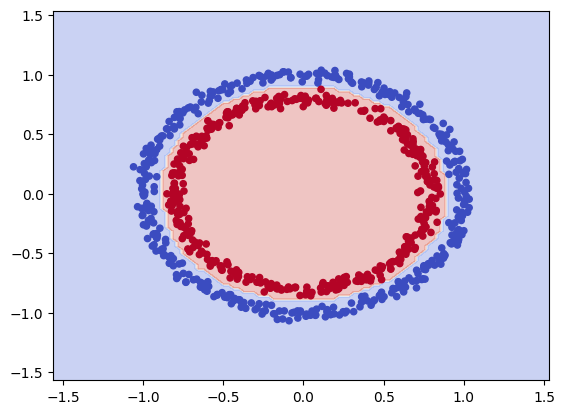

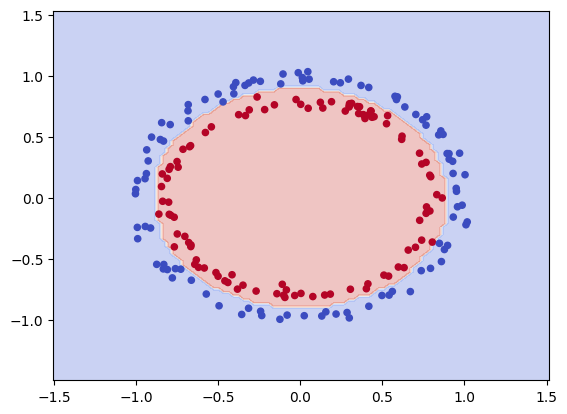

In [30]:
# Decision boundary on training set
plot_decision_boundary(model_trained, X_train, y_train)

# Decision boundary on test set
plot_decision_boundary(model_trained, X_test, y_test)


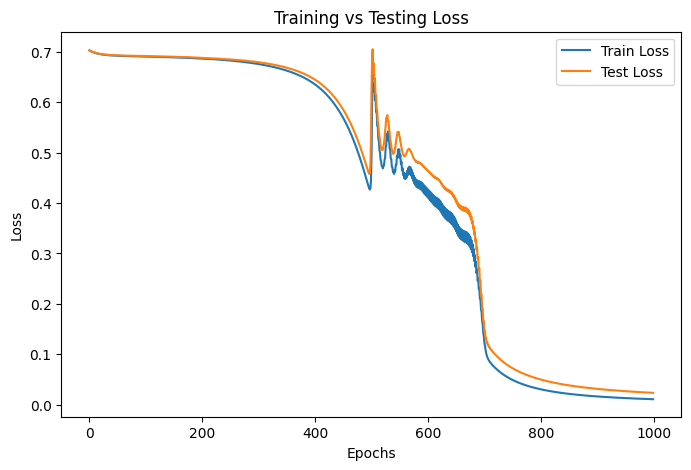

In [31]:
plt.figure(figsize=(8,5))
plt.plot(train_losses, label="Train Loss")
plt.plot(test_losses, label="Test Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training vs Testing Loss")
plt.legend()
plt.show()


## Optional Extra Credit: Adam vs SGD Optimizer Comparison

Compare convergence speed and stability between SGD and Adam optimizers 
using ModelV2 on the circular dataset.


Epoch 0 | Train Loss: 0.6990, Train Acc: 0.5000 | Test Loss: 0.6936, Test Acc: 0.5000
Epoch 10 | Train Loss: 0.6257, Train Acc: 0.9850 | Test Loss: 0.6213, Test Acc: 0.8900
Epoch 20 | Train Loss: 0.3441, Train Acc: 0.9775 | Test Loss: 0.3499, Test Acc: 0.9800
Epoch 30 | Train Loss: 0.0580, Train Acc: 0.9988 | Test Loss: 0.0757, Test Acc: 0.9950
Epoch 40 | Train Loss: 0.0072, Train Acc: 1.0000 | Test Loss: 0.0158, Test Acc: 1.0000
Epoch 50 | Train Loss: 0.0021, Train Acc: 1.0000 | Test Loss: 0.0075, Test Acc: 1.0000
Epoch 60 | Train Loss: 0.0011, Train Acc: 1.0000 | Test Loss: 0.0053, Test Acc: 1.0000
Epoch 70 | Train Loss: 0.0008, Train Acc: 1.0000 | Test Loss: 0.0046, Test Acc: 1.0000
Epoch 80 | Train Loss: 0.0007, Train Acc: 1.0000 | Test Loss: 0.0043, Test Acc: 1.0000
Epoch 90 | Train Loss: 0.0006, Train Acc: 1.0000 | Test Loss: 0.0041, Test Acc: 1.0000
Epoch 100 | Train Loss: 0.0005, Train Acc: 1.0000 | Test Loss: 0.0039, Test Acc: 1.0000
Epoch 110 | Train Loss: 0.0004, Train Acc: 

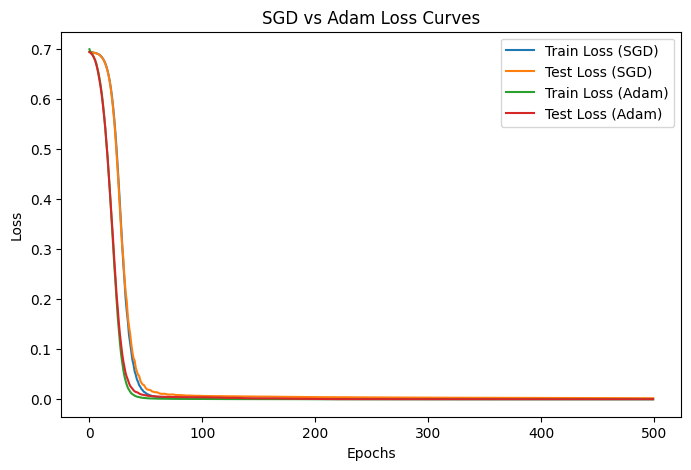

In [36]:
# --- Model and data setup ---
model_adam = ModelV2().to(device)  # Reinitialize model
optimizer_adam = torch.optim.Adam(model_adam.parameters(), lr=0.01)  # Adam optimizer

# --- Train with Adam ---
train_losses_adam, test_losses_adam, train_accs_adam, test_accs_adam = train_and_test_loop(
    model_adam, optimizer_adam, epochs=500  # no need to pass loss_fn; it uses global BCEWithLogitsLoss
)

# --- Compare with previously trained SGD model (ModelV2) ---
# Assume train_losses, test_losses from SGD training are available
plt.figure(figsize=(8,5))
plt.plot(train_losses, label="Train Loss (SGD)")
plt.plot(test_losses, label="Test Loss (SGD)")
plt.plot(train_losses_adam, label="Train Loss (Adam)")
plt.plot(test_losses_adam, label="Test Loss (Adam)")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("SGD vs Adam Loss Curves")
plt.legend()
plt.show()


### Discussion & Conclusion

.Linear models (V0, V1) fail due to nonlinear decision boundary

.Adding depth without activation does not improve performance

.ReLU introduces nonlinearity → successful classification

.Adam optimizer improves convergence speed.